# IRAnalysis User Guide

IRAnalysis is a platform to facilitate reusability of IR spectroscopic data. It was developed for quantitative IR measurements on solid catalysts but can be used for other applications as well. 

Spectroscopic measurements and meta data is processed into a structured data model. Basic analysis methods such as background and baseline correction, peak identification and fitting are provided. All analysis steps are tracked in the data model to enusre replicability at a later date.

This notebook covers the functionalities and workflow of the IRAnalysis platform. Installation instructions are found on [GitHub](https://github.com/FAIRChemistry/IRAnalysis/).



## Table of Contents

- [IRAnalysis User Guide](#iranalysis-user-guide)
- [Installation](#installation)
- [Usage](#usage)
- [Processing Raw Measurement Files](#processing-raw-measurement-files)
    - [Loading Measurement Files](#loading-measurement-files)
    - [Defining Background spectra](#defining-background-spectra)
    - [Adding Metadata](#adding-metadata)
    - [Visualizing Raw Data](#visualizing-raw-data)
- [Quantitative Analysis and Data Manipulation](#quantitative-analysis-and-data-manipulation)
    - [Setting Expected Peaks and Extinction Coefficients](#setting-expected-peaks-and-extinction-coefficients)
    - [Baseline Correction](#baseline-correction)
    - [Visualization](#visualization)
    - [Band Identification](#band-identification)
    - [Band Fitting](#band-fitting)
    - [Manual Adding of Band Data](#manual-adding-of-band-data)
    - [Calculating Number of Active Sites / Species from Curve Area](#calculating-number-of-active-sites--species-from-curve-area)
- [Exporting Data as JSON](#exporting-data-as-json)

## Installation

The tool is built on python 3.10. The following packages are required:

- numpy
- pandas
- matplotlib
- scipy
- astropy
- jupyter
- pybaselines
- sdRDM
***
To install packages with pip or anaconda run either

```bash
python -m pip install numpy pandas matplotlib scipy astropy jupyter pybaselines
```
or  
```bash
conda install numpy pandas matplotlib scipy astropy jupyter pybaselines
```
***
The datamodel is built with [sdRDM](https://github.com/FAIRChemistry/software-driven-rdm). To install either run
```bash
python -m pip install sdRDM
```
or build from source
```bash
git clone https://github.com/JR-1991/software-driven-rdm.git
cd software-driven-rdm
python3 setup.py install
```
***
The tool itself is available from [GitHub](https://github.com/FAIRChemistry/IRAnalysis/) by running:
```bash
git clone https://github.com/FAIRChemistry/IRAnalysis/
```
***

## Usage

The tool is optimized to run in a Jupyter Notebook. Either install a Jupyter Notebook extension to run the notebook in your code editor or run Jupyter Lab in the browser by running
```bash
cd IRAnalysis
jupyter lab 
```


## Processing Raw Measurement Files

The tool can process multiple raw measurement files at once. The files have to be in the same directory and have to be in a tabular format with column for wavenumber and intensity values.
The `ir_file_handler.py` module provieds the `IRDataFiles` class used to process raw measurement files. It is imported from the modules directory:

In [1]:
from modules.ir_file_handler import IRDataFiles

### Loading Measurement Files

In [2]:
path_to_measurement = "./IR_sample_data/"
datamodel_directory = "./datamodel/core/"
MeasurementFiles = IRDataFiles(
    # String with names of people involved in the measurements
    contributors="Doe et al.",
    # Directory where the raw measurement files are stored
    file_directory=path_to_measurement,
    # Directory where the datamodel files are be stored
    datamodel_directory=datamodel_directory,
    # transmission, absorbance or intensity are available
    detection="absorbance", 
    # file extension of the raw measurement files
    extension="csv", 
    # separator used between columns in the raw measurement files
    separator=";", 
    # decimal sign used in the raw measurement files
    decimal_separator=",",
    # header line in the measurement files
    header=None,
    # column sequence in the measurement files
    column_sequence=["wavenumber", "intensity"],
    # Name of the parameter varied between the measurements
    varied_parameter="temperature",
    # varied parameter values, must be same length as the number of files
    varied_parameter_values=["300 °C", "300 °C", "350 °C", "400 °C", "450 °C",],
    # Name of the experiment
    experiment_name="Pyridine Desorption",
)

**Important Notes**

- `detection` argument can be one of the following: `"transmittance"`, `"absorbance"`, `"intensity"`. When using absorbance or intensity, bands are expected to be local maxima in the spectrum (for later analysis). When using transmittance bands are expected to be local minima.
- When dealing with more complicated raw files an individual parser may be neccessary. Indivdual files have to be parsed into a `pandas.DataFrame` containing a `"wavenumber"` and `"intensity"` column. A list of these `DataFrames` can then be passed to `MeasurementFiles.files` which sets up the datamodel using the `DataFrames` instead of raw files:
```python
sample_data_df = pd.DataFrame({
    "wavenumber" = wavenumber_data,
    "intensity" = intensity_data
    })
MeasurementFiles.files = [sample_data_df]
```
***

In [3]:
MeasurementFiles.files

['C:\\Users\\Luca\\Documents\\GitHub\\IRAnalysis\\IR_sample_data\\TO.P123.5_5h-450C.CSV',
 'C:\\Users\\Luca\\Documents\\GitHub\\IRAnalysis\\IR_sample_data\\TO_P123_5_360min-450C_30min-4mbar-Pyr-RT_30min-300C-Pyr-des.CSV',
 'C:\\Users\\Luca\\Documents\\GitHub\\IRAnalysis\\IR_sample_data\\TO_P123_5_360min-450C_30min-4mbar-Pyr-RT_30min-350C-Pyr-des.CSV',
 'C:\\Users\\Luca\\Documents\\GitHub\\IRAnalysis\\IR_sample_data\\TO_P123_5_360min-450C_30min-4mbar-Pyr-RT_30min-400C-Pyr-des.CSV',
 'C:\\Users\\Luca\\Documents\\GitHub\\IRAnalysis\\IR_sample_data\\TO_P123_5_360min-450C_30min-4mbar-Pyr-RT_30min-450C-Pyr-des.CSV']

### Defining Background spectra

`IRDataFiles.set_background([])` takes a list of spectra that are considered background measurements. If the regular file parser is used, the list should contain the file names of the background measurements as strings. If `DataFrames` were parsed, the background spectra can be defined with the index (**index has to be a string**) of the background measurement within the list passed to `Measurement.files`.

```python
MeasurementFiles.set_background(["TO.P123.5_5h-450C"]) # File name without extension when parsing files directly
MeasurementFiles.set_background(["4"]) # only when parsing pd.DataFrames
```
If multiple background spectra are specified, only the last spectrum in the list is used for background subtraction during the analysis.

In [4]:
MeasurementFiles.set_background(["TO.P123.5_5h-450C"])

### Adding Metadata

Various parameters and metadata can be added to the datamodel with `IRDataFiles.fill_static_parameters(dict)`. This data can either be attributed to the entire experiment or individual measurements. By specifying an index when calling the method, the data is only added to the measurement with the corresponding index.

```python
IRDataFiles.fill_static_parameters(dict) # when no index is given dict data is added to entire experiment
```
The following keywords are available in the datamodel and can be used as keywords in the `dict`:
- mass
  - Mass of the IR sample
- sample_area
  - Area of the IR sample
- literature_reference
  - Points to literature references used for the sample preparation
- composition
  - Relative amount of components used in preparation
- probe_molecule
  - Probe molecule used
- sample_preperation
  - Addidional description of preperation parameters.
- measurement_temperature
  - Temperature during the measurement.
- measurement_pressure
  - Pressure during the measurement.
- measurement_geometry
  - Spectrometer geometry used for the measurement.
- desorption_time
  - Time given to the sample to desorb probe molecule.
- desorption_temperature
  - Temperature at which probe molecule desorption is performed.

**Important note**

Numeric values should always be given as a string with their corresponding unit ($3.141\mathrm{\frac{kg m^2}{s^2}}$ as `"3.141 kg m^2 s^-2"`): More information about the string representation of strings is available in the *astropy* [documentation](https://docs.astropy.org/en/stable/units/standard_units.html).

In [5]:
static_parameters = {
    "mass": "0.62 g",
    "sample_area": "1.866 cm^2",
    "composition": "Zeolithe",
    "probe_molecule": "Pyridine",
    "measurement_geometry": "Absorbance",
}
MeasurementFiles.fill_static_parameters(static_parameters, 0) # use for dict static_parameters for measurement 0
MeasurementFiles.fill_static_parameters(static_parameters, 1) # use for dict static_parameters for measurement 1
MeasurementFiles.fill_static_parameters(static_parameters, 2) # use for dict static_parameters for measurement 2
MeasurementFiles.fill_static_parameters(static_parameters, 3) # use for dict static_parameters for measurement 3
MeasurementFiles.fill_static_parameters(static_parameters, 4) # use for dict static_parameters for measurement 4

### Visualizing Raw Data

All loaded data can be shown with `MeasurementFiles.show_raw_data()`. A wavenumber region may be specified as a tuple or list containing two limits.

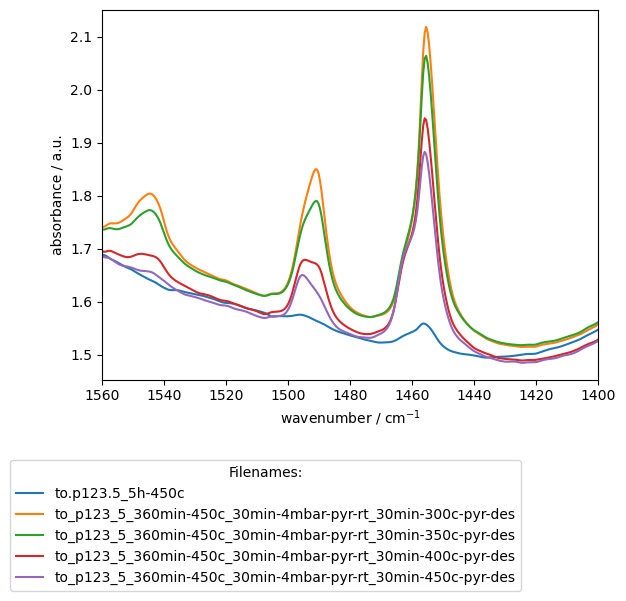

In [6]:
MeasurementFiles.show_raw_data(wavenumber_region=(1560, 1400), 
                               legend=True)

## Quantitative Analysis and Data Manipulation

The `Analysis` module provides methods for automatic baseline and background correction of data, peak finding and fitting, quantitative evaluation of peak areas and visualization. The functionalities can be accessed by passing the `IRDataFiles` object from before to the `IRAnalysis` class.

A wavenumber region should be specified as a tuple or list containing two limits. E.g. form $1560~ \mathrm{cm^{-1}}$ to $1400~ \mathrm{cm^{-1}}$: `region_of_interest=(1560, 1400)`

In [7]:
from modules.analysis import IRAnalysis
Analysis = IRAnalysis(MeasurementFiles,
                      region_of_interest=(1560, 1400))

- **The Analysis class converts all data as intensity data (peaks are local maxima)** for easier analysis.
- The background is automatically subtracted from all sample measurements

### Setting Expected Peaks and Extinction Coefficients

The Bands that are to be quantitatively analyzed should be specified with their name, location and extinction_coeffiecient. The `IRAnalysis` class has a method `set_expected_peaks()` that takes names, locations and coefficients as lists. The lists have to be of the same length and should contain **values with their unit as as string**.

In [8]:
peak_names = ["Lewis", "Mixed", "Bronsted"]
peak_locations = ["1455 cm-1", "1491 cm-1", "1545 cm-1"]
peak_extinction = ["2.22 cm umol-1", "2.22 cm umol-1", "1.67 cm umol-1"] # Micro moles are written as umol
Analysis.set_expected_peaks(peak_names, peak_locations, peak_extinction)

,location,extinction_coefficient
Lewis,1455.0 1 / cm,2.22 cm / umol
Mixed,1491.0 1 / cm,2.22 cm / umol
Bronsted,1545.0 1 / cm,1.67 cm / umol


### Baseline Correction

`IRAnalysis` class has a method `baseline_correction()` to automatically subtract a baseline (in addition to the measured background) from all sample measurements. Subtracting the baseline can be important to ensure good fitting of peaks. The subtracted baseline is saved in the datamodel.

The algorithm used to calculate the baseline is implemented in the *pybaselines* library as `fastchrom()` as published in Johnsen, L., et al. An automated method for baseline correction, peak finding and peak grouping in chromatographic data. *Analyst.* **2013**, 138, 3502-3511.

In [9]:
Analysis.baseline_correction()

The baseline may be inspected and adjusted using the `baseline_control_plot()` method. It allows an easy and interactive adjustment of all baselines using a *jupyter widget*. The adjusted baseline is continuously updated in the datamodel.

In [10]:
Analysis.baseline_control_plot(1, # Spectrum number to start the inspection with
                    save=False, # Set to True if you want to save the plot
                    save_path="baseline_control_plot.png") # Path to save the plot

interactive(children=(IntSlider(value=1, description='Spectrum No.', max=3), IntSlider(value=5, description='H…

### Visualization

The corrected data may be inspected at any point during the analysis using the `plot()` method for a 2D-plot or `plane_plot()` method for a 3D planar plot.

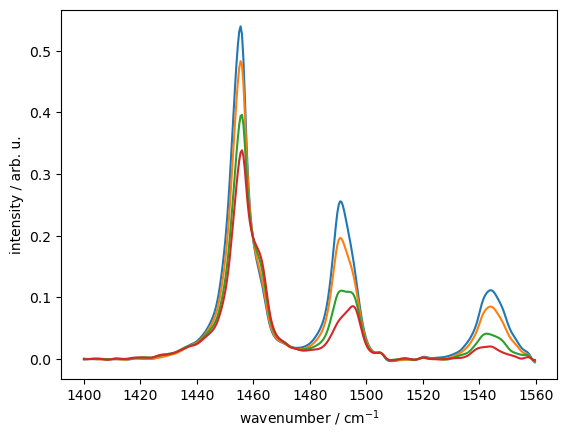

In [11]:
Analysis.plot()

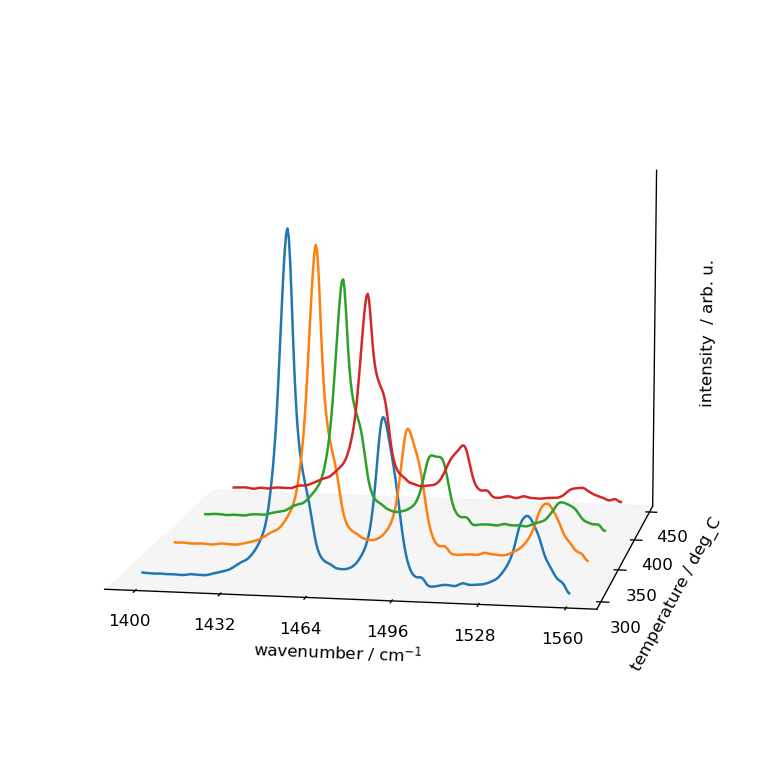

In [12]:
Analysis.plane_plot(save=False,
                    save_path="plane_plot.png")

### Band Identification

The `IRAnalysis` class offers the `find_bands()` method to automatically identify bands based on the previously provided expected peaks. The provided data may be inspected with the class attribute `IRAnalysis.expected_peaks`. The peak finding is based on *scipy*'s `find_peaks()` function.

In [13]:
Analysis.find_bands()

The automatic band identification process may be tuned using the `band_control_plot()` method. The adjustment is performed within an interactive *jupyter widget* using sliders for tuning the peak prominence and height above the baseline.

In [14]:
Analysis.band_control_plot(1, # Spectrum number to start the inspection with
                    save=False, # Set to True if you want to save the plot
                    save_path="band.png") # Path to save the plot

interactive(children=(IntSlider(value=1, description='Spectrum No.', max=3), FloatLogSlider(value=0.01, descri…

### Band Fitting

The `IRAnalysis` class offers the `fit_bands()` method to automatically fit bands that have been previously identified with `find_bands()`. 
To fit every band with a **single Gauss-Lorenz curve** (linear combination of Gaussian and Lorentzian) simply use `fit_bands()` without any arguments.

```python
IRAnalysis.fit_bands()
```
***

If a **different fitting function** is desired for a specific band, the procedure shown below is necessary:
- Start off by defining the function (in this case a linear combination of two Gauss-Lorenz curves)
- The list `models` defines the function to be used for each band (in the order they appear in the spectrum)
- The bounds for each parameter in the fitting functions have to be defined:
    - Bounds for a single function are given as a 2-item tuple or list
        - First item is a list or tuple of the lower bounds
        - Second item is a list or tuple of the upper bounds  
    - The final list `bounds` is a list of the bounds for the individual functions in the order they were specified in `models` 
- The list `p0` contains the inituial guesses for the parameters of each function
    - Store the parameters for each individual function in a list or tuple in the same order as in the function definition
    - The final list `p0` is a list of the parameter list/tuple of the individual functions in the order as specified in `models`
- The list `units` contains the units for each fitting parameter
    - Store the units for the parameters of each individual function in a list or tuple in the same order as in the function definition
    - The final list `units` is a list of the units list/tuple of the individual functions in the order as specified in `models`
- Finally call `IRAnalysis.fit_bands()` and give the specified keyword arguments:
```python
IRAnalysis.fit_bands(fit_models=models,
                   fit_parameter_guesses=p0, 
                   fit_parameter_bounds=bounds,
                   fit_parameter_units=units)
```

In [15]:
from modules.utils import _gauss_lorentz_curve as gl_curve
import numpy as np
def double_gl_curve(x, a_total, a1, x1, w1, l1, x2, w2, l2):
    """Defines a Gauss-Lorentz curve as a linear combination of two single Gauss-Lorentz-Curves.
    The resulting curve's area is scaled with a_total argument.  
    Args:
        x (float): Wavenumber
        a_total (float): Total area of the resulting curve
        a1 (float): Area of the first curve (a2 = a_total - a1)
        x1 (float): Center of the first curve
        w1 (float): Width of the first curve
        l1 (float): Relative Lorentzian amount of the first curve
        x2 (float): Center of the second curve
        w2 (float): Width of the second curve
        l2 (float): Relative Lorentzian amount of the second curve
    """
    a2 = a_total - a1 # Area of the second curve is the total area minus the area of the first curve
    return  gl_curve(x, a1, x1, w1, l1) + gl_curve(x, a2, x2, w2, l2)

# Define which functions to use for fitting as a list in the order of the bands
models = [double_gl_curve, gl_curve, gl_curve]

# Define bounds (lower and upper) for each function
lower_double_gl = [-np.inf, -np.inf, -np.inf, -np.inf, 0, -np.inf, -np.inf, 0] # Lower bounds for double_gl_curve
upper_double_gl = [np.inf, np.inf, np.inf, np.inf, 1, np.inf, np.inf, 1] # Upper bounds for double_gl_curve
lower_single_gl = [-np.inf, -np.inf, -np.inf, 0] # Lower bounds for single Gauss-Lorentz curve,
upper_single_gl = [np.inf, np.inf, np.inf, 1] # Upper bounds for single Gauss-Lorentz curve

# Combine the bounds in a list in the order of the bands
bounds = [(lower_double_gl, upper_double_gl), # bounds for double_gl_curve
          (lower_single_gl, upper_single_gl), # bounds for first single Gauss-Lorentz curve
          (lower_single_gl, upper_single_gl)] # bounds for second single Gauss-Lorentz curve

# Define initial guesses for the fit parameters
p0 = [(4, 2, 1457, 8, 0.5, 1463, 8, 0.5), # Initial guesses for double_gl_curve
      (2, 1490, 8, 0.5), # Initial guesses for first single Gauss-Lorentz curve
      (2, 1545, 8, 0.5)] # Initial guesses for second single Gauss-Lorentz curve

# Define units for the fit parameters
units = [("1/cm", "1/cm", "1/cm", "1/cm", "dimensionless", "1/cm", "1/cm", "dimensionless"),
                           ("1/cm", "1/cm", "1/cm", "dimensionless"),
                           ("1/cm", "1/cm", "1/cm", "dimensionless")]
Analysis.fit_bands(fit_models=models,
                   fit_parameter_guesses=p0, 
                   fit_parameter_bounds=bounds,
                   fit_parameter_units=units)

The automatic band fitting process may be inspected using the `fit_control_plot()` method.

In [16]:
Analysis.fit_control_plot(0,
                    save=False,
                    save_path="fit_control_plot.png")

interactive(children=(IntSlider(value=0, description='Spectrum No.', max=3), Output()), _dom_classes=('widget-…

### Manual Adding of Band Data

If the Analysis of bands is done manually with external software, the method `IRAnalysis.add_band()` may be called to put band data into the datamodel. The available arguments are shown in the function definition below. Arguments such as area and extinction coefficient are necessary if the following quantitative analysis is desired. 

```python
add_band(self,
        spectrum_no:int, 
        assignment:str = "", 
        location:str = "0 / cm", 
        area: str = "0 / cm",
        fit_model: str = "",
        extinction_coefficient: str = "0 m / mol"):
    """Manually adds a band to the analysis object.
    Args:
        spectrum_no (int): Number of the spectrum within the sample measurements
        assignment (str, optional): Description of the band Defaults to "".
        location (str, optional): Location of the band centrum as string with unit. 
            Defaults to "0 / cm".
        area (str, optional): Area of the band as string with unit. Defaults to "0 / cm".
        fit_model (str, optional): Model function used to fit band. Defaults to "".
        extinction_coefficient (str, optional): Extincion coefficient for the band as 
            string with unit Defaults to "0 m / mol".
    """
```

### Calculating Number of Active Sites / Species from Curve Area

The number of active sites per catalyst weight $n_\mathrm{a,w}$ may be calculated automatically from the band area $A$ if the sample area $S$, the extinction coefficient $\varepsilon_\mathrm{a,w}$ and the catalyst mass $m$ were provided before:

$n_\mathrm{a,w}=\frac{A\cdot S}{\varepsilon\cdot m}$

To calculate the number of active sites call `IRAnalysis.quantify()`. The method calculates number and stores it as a result in the data model.

In [17]:
Analysis.quantify()

The results may be displayed as a markdown table by calling the `IRAnalysi.get_results_table()` method. The shown errors are only calculated from statistical errors during the band fitting process.

In [18]:
Analysis.get_results_table()

| temperature / deg_C | **Lewis / 1e-06 mol / g** | **Mixed / 1e-06 mol / g** | **Bronsted / 1e-06 mol / g** |
|---|---|---|---|
| $300.0$ | $8.3 \pm 0.1$ | $4.1 \pm 0.1$ | $2.89 \pm 0.03$ |
| $350.0$ | $7.6 \pm 0.1$ | $3.2 \pm 0.1$ | $2.14 \pm 0.03$ |
| $400.0$ | $6.9 \pm 0.1$ | $2.0 \pm 0.2$ | $1.07 \pm 0.03$ |
| $450.0$ | $7.1 \pm 0.3$ | $1.6 \pm 0.2$ | $0.47 \pm 0.02$ |


The results may also be displayed as a pandas.DataFrame using the `IRAnalysis.get_results_df()` method for easier data extraction.

In [19]:
Analysis.get_results_df()

,temperature_unit,Lewis,Lewis_unit,Lewis_error,Mixed,Mixed_unit,Mixed_error,Bronsted,Bronsted_unit,Bronsted_error
temperature,,,,,,,,,,
300.0,deg_C,8.253512,1e-06 mol / g,0.144115,4.139250,1e-06 mol / g,0.121185,2.891444,1e-06 mol / g,0.031189
350.0,deg_C,7.593073,1e-06 mol / g,0.130434,3.212685,1e-06 mol / g,0.126402,2.141774,1e-06 mol / g,0.031266
400.0,deg_C,6.921417,1e-06 mol / g,0.106934,1.982529,1e-06 mol / g,0.158052,1.074442,1e-06 mol / g,0.029250
450.0,deg_C,7.106124,1e-06 mol / g,0.301569,1.641665,1e-06 mol / g,0.157705,0.469066,1e-06 mol / g,0.016461


The results may also be visualized along the varied parameter using the `IRAnalysis.get_results_plot()` method.

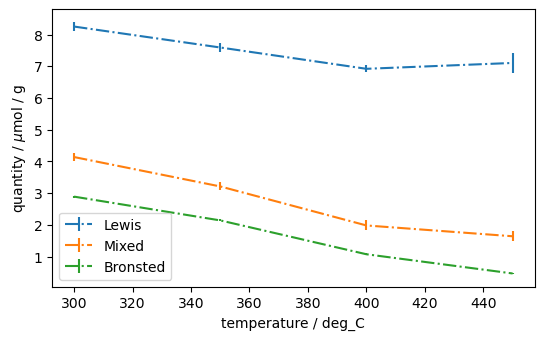

In [20]:
Analysis.get_results_plot()

### Exporting Data as JSON

The datamodel may be exported into a JSON-file using the `IRAnalysis.to_json_file()` method.

In [21]:
Analysis.to_json_file()

data successfully written in output.json.
